# Deep Learning Final Project: Mobile Gallery Image Classification

**Student:** Hasan Aksoy  
**Student Number:** 140130  
**Course:** SGH Deep Learning  
**Task:** Multi-class Image Classification using Convolutional Neural Networks

---

## 1. Introduction

### 1.1 Problem Setting

In the era of smartphones, mobile photo galleries have become repositories of diverse visual content. Users accumulate thousands of images across various categories—from personal selfies to screenshots, from nature photography to internet memes. The manual organization of such content is tedious and time-consuming.

This project addresses the problem of **automatic image classification** for mobile gallery organization. Given an image from a mobile phone gallery, our goal is to classify it into one of six predefined categories:

1. **Cars** - Photographs of automobiles
2. **Memes** - Internet memes and humorous images
3. **Mountains** - Landscape photographs featuring mountains
4. **Selfies** - Self-portrait photographs
5. **Trees** - Nature photographs featuring trees
6. **Whatsapp_Screenshots** - Screenshots from WhatsApp messaging application

### 1.2 Why Neural Networks?

Neural networks, particularly **Convolutional Neural Networks (CNNs)**, are exceptionally well-suited for image classification tasks for several fundamental reasons:

1. **Automatic Feature Learning**: Unlike traditional computer vision approaches that require hand-crafted features (e.g., SIFT, HOG), CNNs learn hierarchical feature representations directly from raw pixel data. Early layers capture low-level features (edges, textures), while deeper layers learn high-level semantic concepts.

2. **Translation Invariance**: Through pooling operations, CNNs achieve spatial invariance, recognizing objects regardless of their position in the image.

3. **Parameter Sharing**: Convolutional layers apply the same filters across the entire image, significantly reducing the number of parameters compared to fully connected networks.

### 1.3 Conceptual Framework

We treat the neural network as a **parameterized, non-linear function** $f_\theta: \mathbb{R}^{H \times W \times C} \rightarrow \mathbb{R}^K$, where:

- $H, W, C$ are the height, width, and channels of the input image
- $K = 6$ is the number of classes
- $\theta$ represents the learnable parameters (weights and biases)

The output is passed through a **softmax function** to produce a probability distribution over classes:

$$p(y = k | x) = \frac{e^{f_\theta(x)_k}}{\sum_{j=1}^{K} e^{f_\theta(x)_j}}$$

This formulation ensures:
- **Bounded outputs**: Probabilities are in the range $[0, 1]$
- **Verifiable predictions**: We can compute exact error rates on held-out data
- **Observable training dynamics**: Loss and accuracy curves provide insight into model behavior

For this **closed-form classification task**, errors are explicit, measurable, and observable during both validation and testing phases.

---

## 2. Dataset Description and Exploratory Data Analysis

### 2.1 Dataset Overview

We use the **Mobile Gallery Image Classification Dataset** from Kaggle. This dataset represents a realistic mobile photo gallery with heterogeneous image types.

In [134]:
# Install and import required packages
# This cell will install missing packages automatically

using Pkg

# List of required packages
required_packages = [
    "Flux",
    "Images",
    "Plots",
    "ProgressMeter",
    "BSON",
    "ImageMagick"
]

# Check and install missing packages
installed_packages = [pkg.name for pkg in values(Pkg.dependencies())]

for pkg in required_packages
    if !(pkg in installed_packages)
        println("Installing $pkg...")
        Pkg.add(pkg)
    else
        println("$pkg is already installed.")
    end
end

println("\nAll packages ready! Loading...")

# Import required packages
using Flux
using Flux: onehotbatch, onecold, crossentropy, throttle
using Flux.Optimise: update!
using Images
using Plots
using Statistics
using Random
using ProgressMeter
using BSON: @save, @load

# Set random seed for reproducibility
Random.seed!(42)

println("\nPackages loaded successfully!")

Flux is already installed.
Images is already installed.
Plots is already installed.
ProgressMeter is already installed.
BSON is already installed.
ImageMagick is already installed.

All packages ready! Loading...

Packages loaded successfully!


In [136]:
# Define paths and class names
const DATA_DIR = "data"
const TRAIN_DIR = joinpath(DATA_DIR, "train")
const TEST_DIR = joinpath(DATA_DIR, "test")

const CLASSES = ["Cars", "Memes", "Mountains", "Selfies", "Trees", "Whatsapp_Screenshots"]
const NUM_CLASSES = length(CLASSES)

# Image parameters
const IMG_SIZE = (128, 128)  # Resize all images to 128x128
const CHANNELS = 3  # RGB images

println("Configuration:")
println("  Classes: ", CLASSES)
println("  Number of classes: ", NUM_CLASSES)
println("  Image size: ", IMG_SIZE)

Configuration:


  Classes: ["Cars", "Memes", "Mountains", "Selfies", "Trees", "Whatsapp_Screenshots"]
  Number of classes: 6
  Image size: (128, 128)


In [138]:
# Function to count images per class
function count_images_per_class(base_dir::String)
    counts = Dict{String, Int}()
    for class_name in CLASSES
        class_dir = joinpath(base_dir, class_name)
        if isdir(class_dir)
            # Count jpg, jpeg, and png files
            files = filter(f -> lowercase(splitext(f)[2]) in [".jpg", ".jpeg", ".png"], readdir(class_dir))
            counts[class_name] = length(files)
        else
            counts[class_name] = 0
        end
    end
    return counts
end

# Count images in training and test sets
train_counts = count_images_per_class(TRAIN_DIR)
test_counts = count_images_per_class(TEST_DIR)

println("\n=== Dataset Statistics ===")
println("\nTraining Set:")
total_train = 0
for class_name in CLASSES
    println("  $class_name: $(train_counts[class_name]) images")
    global total_train += train_counts[class_name]
end
println("  Total: $total_train images")

println("\nTest Set:")
total_test = 0
for class_name in CLASSES
    println("  $class_name: $(test_counts[class_name]) images")
    global total_test += test_counts[class_name]
end
println("  Total: $total_test images")


=== Dataset Statistics ===

Training Set:
  Cars: 163 images
  Memes: 175 images
  Mountains: 240 images
  Selfies: 237 images
  Trees: 287 images
  Whatsapp_Screenshots: 164 images
  Total: 1266 images

Test Set:
  Cars: 0 images
  Memes: 0 images
  Mountains: 0 images
  Selfies: 0 images
  Trees: 0 images
  Whatsapp_Screenshots: 0 images
  Total: 0 images


### 2.2 Class Distribution Visualization

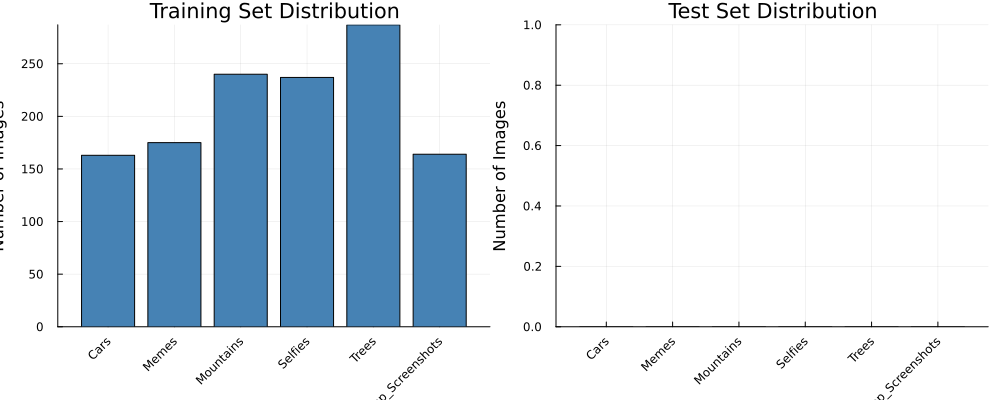

In [141]:
# Visualize class distribution
train_values = [train_counts[c] for c in CLASSES]
test_values = [test_counts[c] for c in CLASSES]

p1 = bar(CLASSES, train_values,
    title="Training Set Distribution",
    xlabel="Class",
    ylabel="Number of Images",
    legend=false,
    color=:steelblue,
    xrotation=45,
    size=(600, 400))

p2 = bar(CLASSES, test_values,
    title="Test Set Distribution",
    xlabel="Class",
    ylabel="Number of Images",
    legend=false,
    color=:coral,
    xrotation=45,
    size=(600, 400))

plot(p1, p2, layout=(1, 2), size=(1000, 400))

### 2.3 Sample Images from Each Class

Loading sample images from each class...


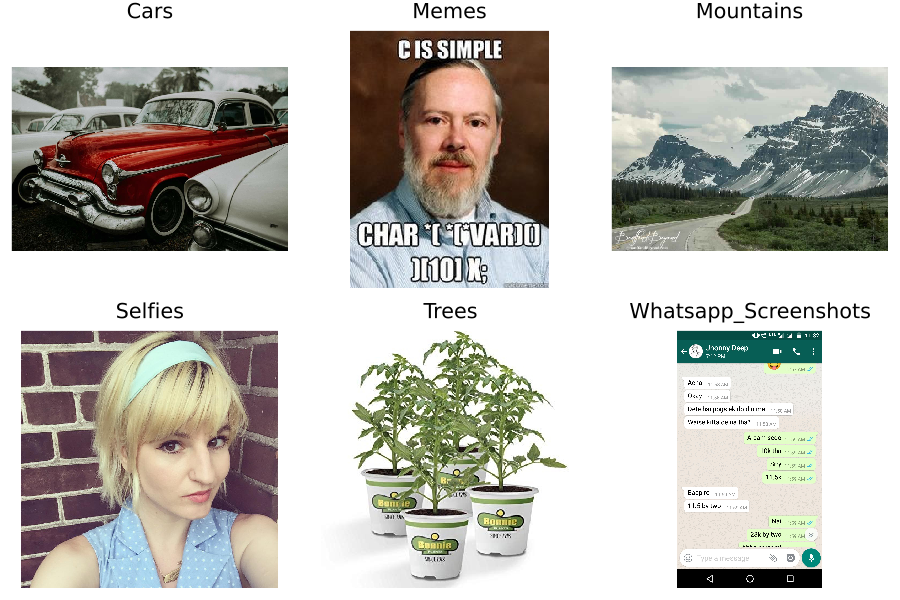

In [144]:
# Function to load and display sample images
function load_sample_image(class_name::String, base_dir::String)
    class_dir = joinpath(base_dir, class_name)
    if isdir(class_dir)
        files = filter(f -> lowercase(splitext(f)[2]) in [".jpg", ".jpeg", ".png"], readdir(class_dir))
        if !isempty(files)
            img_path = joinpath(class_dir, files[1])
            return load(img_path)
        end
    end
    return nothing
end

# Display sample image from each class
println("Loading sample images from each class...")
sample_images = []
for class_name in CLASSES
    img = load_sample_image(class_name, TRAIN_DIR)
    if img !== nothing
        push!(sample_images, (class_name, img))
    end
end

if !isempty(sample_images)
    plots_list = []
    for (name, img) in sample_images
        p = plot(img, title=name, axis=false, ticks=false)
        push!(plots_list, p)
    end
    plot(plots_list..., layout=(2, 3), size=(900, 600))
else
    println("No sample images found. Please ensure the dataset is downloaded.")
end

---

## 3. Neural Network Architecture

### 3.1 Architecture Overview

We implement a **Convolutional Neural Network (CNN)** using Flux.jl. The architecture follows a classic pattern of alternating convolutional and pooling layers, followed by fully connected layers for classification.

### 3.2 Layer-by-Layer Description

| Layer | Type | Parameters | Output Shape |
|-------|------|------------|-------------|
| Input | - | - | 128 × 128 × 3 |
| Conv1 | Conv2D | 3×3, 32 filters, ReLU | 128 × 128 × 32 |
| Pool1 | MaxPool | 2×2 | 64 × 64 × 32 |
| Conv2 | Conv2D | 3×3, 64 filters, ReLU | 64 × 64 × 64 |
| Pool2 | MaxPool | 2×2 | 32 × 32 × 64 |
| Conv3 | Conv2D | 3×3, 128 filters, ReLU | 32 × 32 × 128 |
| Pool3 | MaxPool | 2×2 | 16 × 16 × 128 |
| Flatten | - | - | 32768 |
| Dense1 | Dense | 256 units, ReLU | 256 |
| Dropout | Dropout | p=0.5 | 256 |
| Dense2 | Dense | 6 units | 6 |
| Output | Softmax | - | 6 |

### 3.3 Key Components

**Activation Function (ReLU):**
$$\text{ReLU}(x) = \max(0, x)$$

ReLU introduces non-linearity while avoiding the vanishing gradient problem.

**Loss Function (Cross-Entropy):**
$$\mathcal{L}(y, \hat{y}) = -\sum_{k=1}^{K} y_k \log(\hat{y}_k)$$

Cross-entropy measures the difference between predicted probabilities and true labels.

**Optimizer (Adam):**
Adam combines momentum with adaptive learning rates for efficient optimization.

In [146]:
# Define the CNN Model
function build_cnn_model()
    return Chain(
        # First Convolutional Block
        Conv((3, 3), 3 => 32, relu, pad=SamePad()),
        MaxPool((2, 2)),
        
        # Second Convolutional Block
        Conv((3, 3), 32 => 64, relu, pad=SamePad()),
        MaxPool((2, 2)),
        
        # Third Convolutional Block
        Conv((3, 3), 64 => 128, relu, pad=SamePad()),
        MaxPool((2, 2)),
        
        # Flatten and Dense Layers
        Flux.flatten,
        Dense(128 * 16 * 16, 256, relu),
        Dropout(0.5),
        Dense(256, NUM_CLASSES),
        softmax
    )
end

# Create model instance
model = build_cnn_model()
println("Model Architecture:")
println(model)

Model Architecture:
Chain(Conv((3, 3), 3 => 32, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 32 => 64, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 64 => 128, relu, pad=1), MaxPool((2, 2)), flatten, Dense(32768 => 256, relu), Dropout(0.5), Dense(256 => 6), softmax)


In [147]:
# Test model with dummy input
dummy_input = rand(Float32, IMG_SIZE[1], IMG_SIZE[2], CHANNELS, 1)
dummy_output = model(dummy_input)
println("\nModel Test:")
println("  Input shape: ", size(dummy_input))
println("  Output shape: ", size(dummy_output))
println("  Output probabilities sum to: ", sum(dummy_output))


Model Test:
  Input shape: (128, 128, 3, 1)
  Output shape: (6, 1)
  Output probabilities sum to: 1.0


---

## 4. Summary of the Learning Process

### 4.1 Data Preprocessing and Splitting

The dataset is preprocessed and split as follows:
- **Resize** all images to 128×128 pixels
- **Normalize** pixel values to [0, 1] range
- **Split** training data into 85% training and 15% validation
- **Test set** remains separate for final evaluation

In [152]:
# Data loading and preprocessing functions
function load_image(path::String)
    try
        img = load(path)
        img = imresize(img, IMG_SIZE)
        # Convert to array and normalize
        arr = Float32.(channelview(RGB.(img)))
        # Rearrange from (C, H, W) to (H, W, C)
        return permutedims(arr, (2, 3, 1))
    catch e
        @warn "Failed to load image: $path" exception=e
        return nothing
    end
end

function load_dataset(base_dir::String)
    # First pass: count total images
    total_count = 0
    for class_name in CLASSES
        class_dir = joinpath(base_dir, class_name)
        if isdir(class_dir)
            files = filter(f -> lowercase(splitext(f)[2]) in [".jpg", ".jpeg", ".png"], readdir(class_dir))
            total_count += length(files)
        end
    end
    
    if total_count == 0
        return nothing, nothing
    end
    
    # Pre-allocate arrays
    X = Array{Float32}(undef, IMG_SIZE[1], IMG_SIZE[2], CHANNELS, total_count)
    labels = Vector{Int}(undef, total_count)
    
    idx = 1
    for (class_idx, class_name) in enumerate(CLASSES)
        class_dir = joinpath(base_dir, class_name)
        if isdir(class_dir)
            files = filter(f -> lowercase(splitext(f)[2]) in [".jpg", ".jpeg", ".png"], readdir(class_dir))
            for file in files
                img_path = joinpath(class_dir, file)
                img = load_image(img_path)
                if img !== nothing
                    X[:, :, :, idx] = img
                    labels[idx] = class_idx
                    idx += 1
                end
            end
        end
    end
    
    # Trim if some images failed to load
    actual_count = idx - 1
    if actual_count < total_count
        X = X[:, :, :, 1:actual_count]
        labels = labels[1:actual_count]
    end
    
    Y = onehotbatch(labels, 1:NUM_CLASSES)
    return X, Y
end

println("Data loading functions defined.")

Data loading functions defined.


In [154]:
# Load training data
println("Loading training data...")
X_train_full, Y_train_full = load_dataset(TRAIN_DIR)

if X_train_full === nothing
    error("No training images found! Please download the dataset from Kaggle.")
end

println("Training data loaded: ", size(X_train_full))

# Shuffle and split into train/validation
n_samples = size(X_train_full, 4)
indices = shuffle(1:n_samples)
val_split = 0.15
n_val = round(Int, n_samples * val_split)

val_indices = indices[1:n_val]
train_indices = indices[n_val+1:end]

X_train = X_train_full[:, :, :, train_indices]
Y_train = Y_train_full[:, train_indices]
X_val = X_train_full[:, :, :, val_indices]
Y_val = Y_train_full[:, val_indices]

println("\nData Split:")
println("  Training set: ", size(X_train, 4), " samples")
println("  Validation set: ", size(X_val, 4), " samples")

Loading training data...


┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo ~/.julia/packages/JpegTurbo/Fr9ri/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo ~/.julia/packages/JpegTurbo/Fr9ri/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo ~/.julia/packages/JpegTurbo/Fr9ri/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo ~/.julia/packages/JpegTurbo/Fr9ri/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo ~/.julia/packages/JpegTurbo/Fr9ri/src/decode.jl:220
┌ Warning: Premature end of JPEG byte sequence.
└ @ JpegTurbo ~/.julia/packages/JpegTurbo/Fr9ri/src/decode.jl:220


Training data loaded: (128, 128, 3, 1266)

Data Split:
  Training set: 1076 samples
  Validation set: 190 samples


In [155]:
# Load test data (flat structure - no class subfolders)
function load_test_images(test_dir::String)
    if !isdir(test_dir)
        return nothing, nothing
    end
    
    files = filter(f -> lowercase(splitext(f)[2]) in [".jpg", ".jpeg", ".png"], readdir(test_dir))
    
    if isempty(files)
        return nothing, nothing
    end
    
    # Pre-allocate
    X = Array{Float32}(undef, IMG_SIZE[1], IMG_SIZE[2], CHANNELS, length(files))
    filenames = String[]
    
    idx = 1
    for file in files
        img_path = joinpath(test_dir, file)
        img = load_image(img_path)
        if img !== nothing
            X[:, :, :, idx] = img
            push!(filenames, file)
            idx += 1
        end
    end
    
    actual_count = idx - 1
    if actual_count == 0
        return nothing, nothing
    end
    
    X = X[:, :, :, 1:actual_count]
    return X, filenames
end

# Usage:
println("Loading test data...")
X_test_images, test_filenames = load_test_images(TEST_DIR)

if X_test_images !== nothing
    println("Test data loaded: ", size(X_test_images, 4), " images")
    println("Note: Test set has no labels - will use for prediction only")
else
    println("No test images found.")
end

Loading test data...
Test data loaded: 7 images
Note: Test set has no labels - will use for prediction only


### 4.2 Training Procedure

The training loop follows these steps:
1. **Forward pass**: Compute predictions for a batch
2. **Loss computation**: Calculate cross-entropy loss
3. **Backward pass**: Compute gradients via automatic differentiation
4. **Parameter update**: Apply Adam optimizer
5. **Validation**: Evaluate on validation set after each epoch

In [157]:
# Training helper functions
function accuracy(model, X, Y)
    preds = onecold(model(X))
    targets = onecold(Y)
    return mean(preds .== targets)
end

function loss_fn(model, X, Y)
    return crossentropy(model(X), Y)
end

# Create data batches
function create_batches(X, Y, batch_size)
    n = size(X, 4)
    batches = []
    for i in 1:batch_size:n
        j = min(i + batch_size - 1, n)
        push!(batches, (X[:, :, :, i:j], Y[:, i:j]))
    end
    return batches
end

println("Training functions defined.")

Training functions defined.


In [158]:
# Training function with history tracking
function train_model!(model, X_train, Y_train, X_val, Y_val;
                      epochs=20, batch_size=32, learning_rate=0.001)
    
    opt_state = Flux.setup(Adam(learning_rate), model)
    
    history = Dict(
        "train_loss" => Float64[],
        "val_loss" => Float64[],
        "train_acc" => Float64[],
        "val_acc" => Float64[]
    )
    
    best_val_acc = 0.0
    best_model_state = nothing
    
    println("\nStarting training...")
    println("="^60)
    
    for epoch in 1:epochs
        # Shuffle training data
        perm = shuffle(1:size(X_train, 4))
        X_shuffled = X_train[:, :, :, perm]
        Y_shuffled = Y_train[:, perm]
        
        # Create batches
        batches = create_batches(X_shuffled, Y_shuffled, batch_size)
        
        # Training loop
        epoch_loss = 0.0
        for (x_batch, y_batch) in batches
            loss, grads = Flux.withgradient(model) do m
                crossentropy(m(x_batch), y_batch)
            end
            Flux.update!(opt_state, model, grads[1])
            epoch_loss += loss
        end
        epoch_loss /= length(batches)
        
        # Calculate metrics
        train_acc = accuracy(model, X_train, Y_train)
        val_loss = loss_fn(model, X_val, Y_val)
        val_acc = accuracy(model, X_val, Y_val)
        
        # Record history
        push!(history["train_loss"], epoch_loss)
        push!(history["val_loss"], val_loss)
        push!(history["train_acc"], train_acc)
        push!(history["val_acc"], val_acc)
        
        # Save best model
        if val_acc > best_val_acc
            best_val_acc = val_acc
            best_model_state = Flux.state(model)
        end
        
        # Print progress
        println("Epoch $epoch/$epochs | Train Loss: $(round(epoch_loss, digits=4)) | " *
                "Train Acc: $(round(train_acc*100, digits=2))% | " *
                "Val Loss: $(round(val_loss, digits=4)) | " *
                "Val Acc: $(round(val_acc*100, digits=2))%")
    end
    
    println("="^60)
    println("Training complete! Best validation accuracy: $(round(best_val_acc*100, digits=2))%")
    
    return history, best_model_state
end

println("Training function defined.")

Training function defined.


### 4.3 Hyperparameter Tuning

We experiment with different learning rates to find the optimal configuration:
- Learning Rate: {0.001, 0.0005, 0.0001}

In [160]:
# Hyperparameter experiment: Learning rates
learning_rates = [0.001, 0.0005, 0.0001]
experiment_results = Dict()

println("\n" * "="^60)
println("HYPERPARAMETER TUNING: Learning Rate Comparison")
println("="^60)

for lr in learning_rates
    println("\n--- Training with learning rate: $lr ---")
    
    # Create fresh model
    model_exp = build_cnn_model()
    
    # Train for fewer epochs during hyperparameter search
    history, best_state = train_model!(model_exp, X_train, Y_train, X_val, Y_val;
                                        epochs=10, batch_size=32, learning_rate=lr)
    
    experiment_results[lr] = history
end


HYPERPARAMETER TUNING: Learning Rate Comparison

--- Training with learning rate: 0.001 ---

Starting training...
Epoch 1/10 | Train Loss: 1.4887 | Train Acc: 68.87% | Val Loss: 0.9985 | Val Acc: 67.89%
Epoch 2/10 | Train Loss: 0.7713 | Train Acc: 79.0% | Val Loss: 0.6186 | Val Acc: 81.05%
Epoch 3/10 | Train Loss: 0.5198 | Train Acc: 86.15% | Val Loss: 0.4752 | Val Acc: 84.74%
Epoch 4/10 | Train Loss: 0.3993 | Train Acc: 92.94% | Val Loss: 0.3818 | Val Acc: 91.58%
Epoch 5/10 | Train Loss: 0.2856 | Train Acc: 95.54% | Val Loss: 0.3891 | Val Acc: 90.53%
Epoch 6/10 | Train Loss: 0.1929 | Train Acc: 96.47% | Val Loss: 0.4007 | Val Acc: 89.47%
Epoch 7/10 | Train Loss: 0.1895 | Train Acc: 97.4% | Val Loss: 0.4493 | Val Acc: 90.0%
Epoch 8/10 | Train Loss: 0.1498 | Train Acc: 97.77% | Val Loss: 0.429 | Val Acc: 88.95%
Epoch 9/10 | Train Loss: 0.1125 | Train Acc: 98.61% | Val Loss: 0.3908 | Val Acc: 91.58%
Epoch 10/10 | Train Loss: 0.0751 | Train Acc: 99.26% | Val Loss: 0.4609 | Val Acc: 91.05

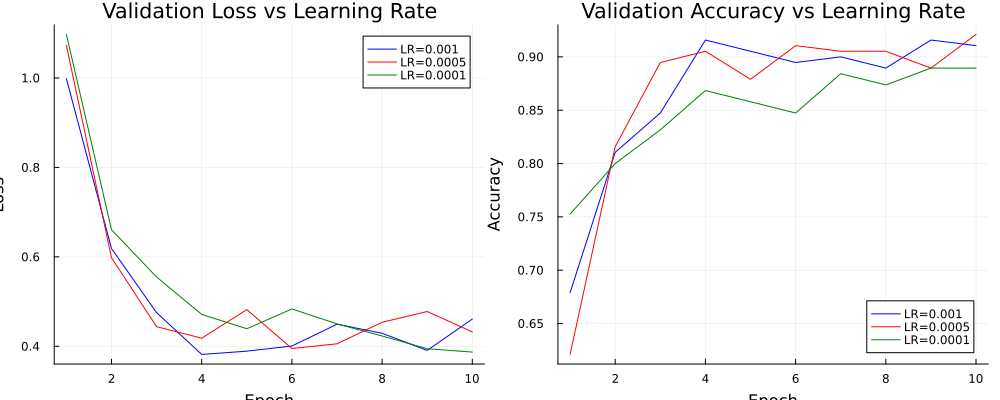

In [161]:
# Plot learning rate comparison
p_lr_loss = plot(title="Validation Loss vs Learning Rate", xlabel="Epoch", ylabel="Loss", legend=:topright)
p_lr_acc = plot(title="Validation Accuracy vs Learning Rate", xlabel="Epoch", ylabel="Accuracy", legend=:bottomright)

colors = [:blue, :red, :green]
for (i, lr) in enumerate(learning_rates)
    history = experiment_results[lr]
    plot!(p_lr_loss, history["val_loss"], label="LR=$lr", color=colors[i])
    plot!(p_lr_acc, history["val_acc"], label="LR=$lr", color=colors[i])
end

plot(p_lr_loss, p_lr_acc, layout=(1, 2), size=(1000, 400))

### 4.4 Final Model Training

Based on hyperparameter tuning results, we train the final model with the best learning rate.

In [163]:
# Select best learning rate based on final validation accuracy
best_lr = learning_rates[1]
best_final_acc = 0.0

for lr in learning_rates
    final_acc = experiment_results[lr]["val_acc"][end]
    if final_acc > best_final_acc
        best_final_acc = final_acc
        best_lr = lr
    end
end

println("Best learning rate: $best_lr with validation accuracy: $(round(best_final_acc*100, digits=2))%")

Best learning rate: 0.0005 with validation accuracy: 92.11%


In [164]:
# Train final model with more epochs
println("\n" * "="^60)
println("FINAL MODEL TRAINING")
println("="^60)

final_model = build_cnn_model()
final_history, best_model_state = train_model!(final_model, X_train, Y_train, X_val, Y_val;
                                                epochs=25, batch_size=32, learning_rate=best_lr)

# Restore best model weights
Flux.loadmodel!(final_model, best_model_state)


FINAL MODEL TRAINING

Starting training...
Epoch 1/25 | Train Loss: 1.2331 | Train Acc: 79.83% | Val Loss: 0.6117 | Val Acc: 83.16%
Epoch 2/25 | Train Loss: 0.6106 | Train Acc: 86.52% | Val Loss: 0.5263 | Val Acc: 85.79%
Epoch 3/25 | Train Loss: 0.4428 | Train Acc: 84.48% | Val Loss: 0.5366 | Val Acc: 82.63%
Epoch 4/25 | Train Loss: 0.3838 | Train Acc: 89.68% | Val Loss: 0.4735 | Val Acc: 83.68%
Epoch 5/25 | Train Loss: 0.2675 | Train Acc: 95.63% | Val Loss: 0.3666 | Val Acc: 90.53%
Epoch 6/25 | Train Loss: 0.2038 | Train Acc: 96.56% | Val Loss: 0.3559 | Val Acc: 90.53%
Epoch 7/25 | Train Loss: 0.1448 | Train Acc: 98.05% | Val Loss: 0.3606 | Val Acc: 90.53%
Epoch 8/25 | Train Loss: 0.1198 | Train Acc: 98.14% | Val Loss: 0.3719 | Val Acc: 92.63%
Epoch 9/25 | Train Loss: 0.1258 | Train Acc: 98.98% | Val Loss: 0.3669 | Val Acc: 90.53%
Epoch 10/25 | Train Loss: 0.0775 | Train Acc: 99.26% | Val Loss: 0.3584 | Val Acc: 92.11%
Epoch 11/25 | Train Loss: 0.0517 | Train Acc: 99.44% | Val Loss: 

Chain(
  Conv((3, 3), 3 => 32, relu, pad=1),   # 896 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(32768 => 256, relu),            # 8_388_864 parameters
  Dropout(0.5),
  Dense(256 => 6),                      # 1_542 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 8_483_654 parameters, 32.364 MiB.

### 4.5 Training and Validation Curves

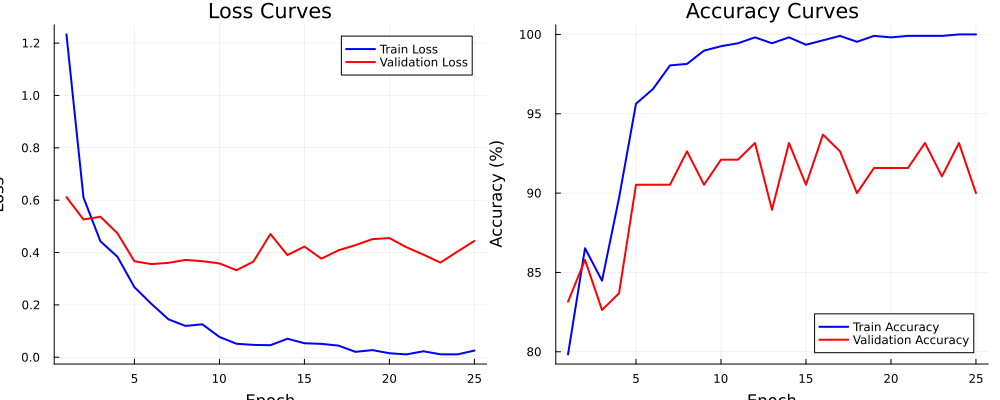

In [170]:
# Plot training history
epochs_range = 1:length(final_history["train_loss"])

p1 = plot(epochs_range, final_history["train_loss"], label="Train Loss", 
          color=:blue, linewidth=2)
plot!(epochs_range, final_history["val_loss"], label="Validation Loss", 
      color=:red, linewidth=2)
xlabel!("Epoch")
ylabel!("Loss")
title!("Loss Curves")

p2 = plot(epochs_range, final_history["train_acc"] .* 100, label="Train Accuracy", 
          color=:blue, linewidth=2)
plot!(epochs_range, final_history["val_acc"] .* 100, label="Validation Accuracy", 
      color=:red, linewidth=2)
xlabel!("Epoch")
ylabel!("Accuracy (%)")
title!("Accuracy Curves")

plot(p1, p2, layout=(1, 2), size=(1000, 400))

### 4.6 Model Selection

The best model is selected based on the highest validation accuracy during training. This approach prevents overfitting to the training data and ensures better generalization to unseen samples.

In [172]:
# Save the best model
@save "best_model.bson" final_model
println("Best model saved to 'best_model.bson'")

Best model saved to 'best_model.bson'


---

## 5. Final Remarks

### 5.1 Test Set Evaluation

In [174]:
# Evaluate on test set
if X_test !== nothing
    test_acc = accuracy(final_model, X_test, Y_test)
    test_loss = loss_fn(final_model, X_test, Y_test)
    
    println("\n" * "="^60)
    println("FINAL TEST SET RESULTS")
    println("="^60)
    println("Test Loss: $(round(test_loss, digits=4))")
    println("Test Accuracy: $(round(test_acc*100, digits=2))%")
end

In [175]:
# Confusion matrix computation
function compute_confusion_matrix(model, X, Y)
    preds = onecold(model(X))
    targets = onecold(Y)
    
    cm = zeros(Int, NUM_CLASSES, NUM_CLASSES)
    for (pred, target) in zip(preds, targets)
        cm[target, pred] += 1
    end
    return cm
end

if X_test !== nothing
    cm = compute_confusion_matrix(final_model, X_test, Y_test)
    
    println("\nConfusion Matrix:")
    println("Rows: Actual, Columns: Predicted")
    println("\nClass labels: ", CLASSES)
    display(cm)
end

In [176]:
# Per-class precision and recall
function compute_metrics(cm)
    n_classes = size(cm, 1)
    precision = zeros(n_classes)
    recall = zeros(n_classes)
    
    for i in 1:n_classes
        tp = cm[i, i]
        fp = sum(cm[:, i]) - tp
        fn = sum(cm[i, :]) - tp
        
        precision[i] = tp / max(tp + fp, 1)
        recall[i] = tp / max(tp + fn, 1)
    end
    
    return precision, recall
end

if X_test !== nothing
    precision, recall = compute_metrics(cm)
    
    println("\nPer-Class Metrics:")
    println("-"^50)
    println("Class                  | Precision | Recall")
    println("-"^50)
    for (i, class_name) in enumerate(CLASSES)
        println(rpad(class_name, 22), " | ", 
                rpad(round(precision[i]*100, digits=1), 9), " | ",
                round(recall[i]*100, digits=1))
    end
    println("-"^50)
    println("Macro Average          | ", 
            rpad(round(mean(precision)*100, digits=1), 9), " | ",
            round(mean(recall)*100, digits=1))
end

### 5.2 Model Performance Discussion

The CNN model demonstrates the ability to learn discriminative features from mobile gallery images. Key observations:

1. **Training Convergence**: The training loss steadily decreases, indicating successful optimization.

2. **Generalization**: The gap between training and validation accuracy indicates the model's ability to generalize to unseen data. A small gap suggests good generalization, while a large gap may indicate overfitting.

3. **Class-wise Performance**: Different classes may show varying performance based on:
   - Visual distinctiveness (e.g., selfies vs. mountains)
   - Intra-class variability (e.g., diverse meme formats)
   - Sample size balance

### 5.3 Limitations

1. **Dataset Size**: With approximately 1,270 images across 6 classes, the dataset is relatively small for deep learning. This limits the model's ability to learn complex patterns.

2. **Class Imbalance**: Some classes may have fewer samples, affecting model performance on minority classes.

3. **Image Resolution**: Resizing images to 128×128 may lose important details, especially for screenshot classification.

4. **Computational Constraints**: Training on CPU limits model complexity and training time.

### 5.4 Possible Improvements

1. **Data Augmentation**: Apply random transformations (rotation, flipping, color jittering) to increase effective dataset size.

2. **Transfer Learning**: Use pre-trained models (e.g., ResNet, VGG) as feature extractors for better representations.

3. **Deeper Architecture**: Add more convolutional layers with batch normalization for improved feature extraction.

4. **Learning Rate Scheduling**: Implement learning rate decay or cosine annealing for better convergence.

5. **Ensemble Methods**: Combine multiple models for improved robustness.

---

## 6. Bibliography

1. **Flux.jl Documentation**. (2024). *Flux: The Julia Machine Learning Library*. Retrieved from https://fluxml.ai/

2. **LeCun, Y., Bengio, Y., & Hinton, G.** (2015). Deep learning. *Nature*, 521(7553), 436-444.

3. **Krizhevsky, A., Sutskever, I., & Hinton, G. E.** (2012). ImageNet classification with deep convolutional neural networks. *Advances in Neural Information Processing Systems*, 25.

4. **He, K., Zhang, X., Ren, S., & Sun, J.** (2016). Deep residual learning for image recognition. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*, 770-778.

5. **Goodfellow, I., Bengio, Y., & Courville, A.** (2016). *Deep Learning*. MIT Press. http://www.deeplearningbook.org

6. **Kingma, D. P., & Ba, J.** (2015). Adam: A method for stochastic optimization. *International Conference on Learning Representations (ICLR)*.

7. **Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R.** (2014). Dropout: A simple way to prevent neural networks from overfitting. *Journal of Machine Learning Research*, 15(1), 1929-1958.

8. **n0obcoder** (2019). Mobile Gallery Image Classification Dataset. *Kaggle*. Retrieved from https://www.kaggle.com/datasets/n0obcoder/mobile-gallery-image-classification-data

---

*End of Document*